In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import pickle

rho   =  917.      # kg/m3
g     =    9.80665 # m/s2
fd    =    1.9E-24 # # pa-3 s-1 # this value and dimension is only correct for n=3
fs    =    5.7E-20 # # pa-3 m2 s-1 # this value and dimension is only correct for n=3


# this ELA list is not quite systematic, so make it systematic!
# elalist = np.array([1800.])  # m , 1750., 1700., 1500., 2200., 1900., 1800.,
# elayear = np.array([ 500], dtype=int)  # years    ,    100,   100,   150,    10,   100,   100

cd    = 2/5*(rho**3)*(g**3)*fd  # <<< this must be adjused according to your discretisation -- Done
cs    = (rho**3)*(g**3)*fs  # <<< this must be adjused according to your discretisation -- Done


def get_bedrock(xaxis,slope=0.08):
    '''
    Function to get bedrock. 
    IN: 
    xaxis = array
    slope = slope of underground, scalar
    OUT:
    bedrock profile
    '''
    # here you put in your own equation that defines the bedrock
    bedrock = 2000. - xaxis*slope
    return bedrock

In [2]:

def icemodel(elalist,elayear,totL=20000,dx=100,ntpy=200,ZeroFluxBoundary=True,FluxAtPoints=True,ndyfigure=5,dbdh=0.007, maxb=2):
    StopWhenOutOfDomain = True  
    # Start calculations
    # constants that rely on input
    nx    = int(totL/dx)
    dx    = totL/nx       # redefine, as it     
    xaxis = np.linspace(0,totL,nx,False) + dx*0.5
    xhaxs = np.linspace(dx,totL,nx-1,False) / 1000.

    bedrock = get_bedrock(xaxis)

    dt    = 365.*86400./ntpy # in seconds!
    

    hice   = np.zeros(nx)    # ice thickness
    dhdx   = np.zeros(nx)    # the local gradient of h
    fluxd  = np.zeros(nx+2)  # this will be the flux per second!!!!
    fluxs  = np.zeros(nx+2)  # this will be the flux per second!!!!
    dhdtif = np.zeros(nx)    # change in ice thickness due to the ice flux, per second
    smb    = np.zeros(nx)

    # preparations for the ela-selection
    # elaswch is a list of time steps on which a new ela value should be used.
    nyear    = int(np.sum(elayear))
    nela     = np.size(elalist)

    assert nela == np.size(elayear), "the arrays of elalist and elayear does not have the same length!" 
    elaswch = np.zeros(nela)
    for i in range(0,nela-1):
        elaswch[i+1] = elaswch[i] + (elayear[i]*ntpy)
    ela     = elalist[0]
    

    # preparations for the animation
    nframes  = nyear//ndyfigure + 1
    hsurfmem = np.zeros([nx,nframes])
    smbmem   = np.zeros([nx,nframes])
    ifdmem   = np.zeros([nx,nframes])
    fldmem   = np.zeros([nx-1,nframes])
    flsmem   = np.zeros([nx-1,nframes])
    iframes  = 0

    # preparations for response time calculations
    lengthmem = np.zeros(nyear+1)
    volumemem = np.zeros(nyear+1)
    elamemory = np.zeros(nyear+1)
    yearlist  = np.arange(nyear+1)
    
    # (re)set initial values so that the accumulation area has glacier right away.
    hice = np.where(bedrock>ela, np.where(hice<0.11, 0.11, hice), hice)
    
    lengthmem[0] = np.sum(np.where(hice>0.1, dx, 0.))
    volumemem[0] = np.sum(hice)*dx
    elamemory[0] = ela


    #0-----------------------------------------------------------------------------
    print("Run model for {0:3d} years".format(nyear))

    for it in range(1, ntpy*nyear+1):
        h = hice + bedrock
        if FluxAtPoints:
            dhdx[1:-1] = (h[2:]-h[:-2])/(2*dx)

            # the following equations needs to be adjusted according to your discretisation
            # note that flux[1] is at the point 0
            fluxd[1:-1] = cd * (dhdx)**3 * (hice)**5  
            fluxs[1:-1] = cs * (dhdx)**3 * (hice)**3

            # derive flux convergence
            dhdtif[:]  = (fluxd[2:]-fluxd[:-2]+fluxs[2:]-fluxs[:-2])/(2*dx)
        else:
            # the following equations needs to be adjusted according to your discretisation
            dhdx[:-1]  = ((h[1:]-h[:-1])/dx) # so 0 is at 1/2 actually
            # note that flux[1] is at the point 1/2
            fluxd[1:-2] = cd * dhdx[:-1]**3 * ( ((hice[1:]**5)+(hice[:-1])**5) * 0.5 )
            fluxs[1:-2] = cs * dhdx[:-1]**3 * ( ((hice[1:]**3)+(hice[:-1])**3) * 0.5 )

            # derive flux convergence
            dhdtif[:]  = (fluxd[1:-1]-fluxd[:-2] + fluxs[1:-1]-fluxs[:-2])/dx

        # calculate smb (per year)
        # first update ela (once a year)
        if it%ntpy == 1:
            # lists the elements of elaswch that are equal or smaller than it
            [ielanow] = np.nonzero(elaswch<=it) 
            # the last one is the current ela
            ela       = elalist[ielanow[-1]]   
    
        smb[:] = (h-ela)*dbdh
        smb[:] = np.where(smb>maxb, maxb, smb) 
        
        
        
        hice   += smb/ntpy + dt*dhdtif
        hice[:] = np.where(hice<0., 0., hice) # remove negative ice thicknesses

        if ZeroFluxBoundary == False:
            hice[0] = hice[-1] = 0.

        if it%ntpy == 0:
            if np.any(np.isnan(hice)):
                print('Values got NaN!')
                break
            iy = it//ntpy
            lengthmem[iy] = np.sum(np.where(hice>0.1, dx, 0.))
            volumemem[iy] = np.sum(hice)*dx
            elamemory[iy] = ela

        if it%(ndyfigure*ntpy) == 0:
            iframes            += 1
            hsurfmem[:,iframes] = hice + bedrock
            smbmem[:,iframes]   = smb
            ifdmem[:,iframes]   = dhdtif[:]*365.*86400.
            fldmem[:,iframes]   = -fluxd[1:-2]*365.*86400.
            flsmem[:,iframes]   = -fluxs[1:-2]*365.*86400.
            if StopWhenOutOfDomain:
                if hice[-1]>1.:
                    print("Ice at end of domain!")
                    break
                    
#         runs = 0
#         if it%(ntpy*ndyfigure) == 0:
#             runs +=1
#             if balance(smb[:runs]):
#                 print(it)
#                 break

    #------------------------------------------------------------------------------        
    # at this point, the simulation is completed.        
    # the following is needed to make the animation        
    fig  = plt.figure()
    ax1  = fig.add_subplot(311, autoscale_on=False, xlim=(0,totL/1000.), \
                          ylim=(np.min(bedrock),np.max(hsurfmem)+10.))
    ax1.set_ylabel('meter')
    ax1.set_xlabel('km')
    mina2 = min(np.min(smbmem),np.min(ifdmem))
    maxa2 = max(np.max(smbmem),np.max(ifdmem))
    ax2   = fig.add_subplot(312, autoscale_on=False, xlim=(0,totL/1000.), \
                          ylim=(mina2,maxa2))
    ax2.set_ylabel('I dont know')
    ax2.set_xlabel('km')
    mina3 = min(np.min(fldmem),np.min(flsmem))
    maxa3 = max(np.max(fldmem),np.max(flsmem))
    ax3   = fig.add_subplot(313, autoscale_on=False, xlim=(0,totL/1000.), \
                          ylim=(mina3,maxa3))
    ax3.set_xlabel('km')
    ax3.set_ylabel('fluxd/fluxm')


    # define the line types
    bedrline, = ax1.plot([],[],'-', c='saddlebrown') 
    hsrfline, = ax1.plot([],[],'-', c='navy') #bedrline, +total surface 
    
    time_template = 'time = %d y'
    time_text = ax1.text(0.5, 0.92, '', transform=ax1.transAxes )
    smbline,  = ax2.plot([],[],'-', c='navy') #surface mass balance
    ifdline,  = ax2.plot([],[],'-', c='red') #ifd
    fxdline,  = ax3.plot([],[],'-', c='navy') #flux
    fxsline,  = ax3.plot([],[],'-', c='red') #flux

    # initialize the animation
    def init_anim():
        '''function for initial animamtion'''
        bedrline.set_data([], [])
        hsrfline.set_data([], [])
        time_text.set_text('')
        smbline.set_data([], [])
        ifdline.set_data([], [])
        fxdline.set_data([], [])
        fxsline.set_data([], [])

        return bedrline, hsrfline, time_text, smbline, ifdline, fxdline, fxsline

    # update the animation with data for saved frame #tf
    def animate(tf):
        bedrline.set_data(xaxis/1000., bedrock)
        hsrfline.set_data(xaxis/1000., hsurfmem[:,tf]) 
        time_text.set_text(time_template % int(tf*ndyfigure))
        smbline.set_data(xaxis/1000.,  smbmem[:,tf])
        ifdline.set_data(xaxis/1000.,  ifdmem[:,tf])
        fxdline.set_data(xhaxs      ,  fldmem[:,tf])
        fxsline.set_data(xhaxs      ,  flsmem[:,tf])
        return bedrline, hsrfline, time_text, smbline, ifdline, fxdline, fxsline

    # call and run animation
    ani = animation.FuncAnimation(fig, animate, np.arange(iframes),
             interval=25, blit=True, init_func=init_anim) 
    
    writergif = animation.PillowWriter(fps=30)
    
    f = os.path.join('..', 'Plots', 'animation.gif')
    # f = r"c://Users/lasse/Documents/IC/animation.gif" 
    ani.save(f, writer=writergif)
#     plt.show()
    # SAVING PYTHON MOVIES IS PLATFORM DEPENDEND.     

    
    #------------------------------------------------------------------------------ 
    # postprocessing

    # The first ela value is excluded from the analysis as that has the spin-up
    # Here, the length is used for the responsetime. One could also take the mass. 
    #  If desired, do not use lengthmem but volumemem.


    fig2,ax2a = plt.subplots()
    ax2a.plot(yearlist,lengthmem/1000. ,'k') #Black line 
    ax2a.set_xlabel('Model year (yr)')
    ax2a.set_ylabel('Glacier length (km)')
    ax2a.set_xlim([0, nyear])
    lmima = [ np.min(lengthmem/1000.), np.max(lengthmem/1000.) ]


    ax2b  = ax2a.twinx()
    color = 'tab:red'
    ax2b.plot(yearlist, elamemory, color=color) #Red line
    ax2b.set_ylabel('Ela', color=color)
    ax2b.tick_params(axis='y', labelcolor=color)   
    
    returndict = {
        'ntdy':ntpy,
        'dx':dx,
        'years':yearlist,
        'Glacier Length':lengthmem,
        'Glacier Volume':volumemem,
        'Glacier ELA':elamemory,
        'Glacier Height':hsurfmem,
        'Surface Mass Balance': smbmem,
        'ifd':ifdmem,
        'fld':fldmem,
        'fls':flsmem,
    }
    return returndict

                        

                        


In [136]:
def icemodel(elalist,elayear,totL=20000,dx=100,ntpy=200,ZeroFluxBoundary=True,FluxAtPoints=True,ndyfigure=5,dbdh=0.007, maxb=2, initial_state=None, savename=None):
    StopWhenOutOfDomain = True  
    # Start calculations
    # constants that rely on input

    if dx < 100:
        ntpy = ntpy*8

    if initial_state is None:
        nx    = int(totL/dx)
        dx    = totL/nx       # redefine, as it     
        xaxis = np.linspace(0,totL,nx,False) + dx*0.5
        xhaxs = np.linspace(dx,totL,nx-1,False) / 1000.

        bedrock = get_bedrock(xaxis)

        dt    = 365.*86400./ntpy # in seconds!
        
        hice   = np.zeros(nx)    # ice thickness
        dhdx   = np.zeros(nx)    # the local gradient of h
        fluxd  = np.zeros(nx+2)  # this will be the flux per second!!!!
        fluxs  = np.zeros(nx+2)  # this will be the flux per second!!!!
        dhdtif = np.zeros(nx)    # change in ice thickness due to the ice flux, per second
        smb    = np.zeros(nx)

        # preparations for the ela-selection
        # elaswch is a list of time steps on which a new ela value should be used.
        nyear    = int(np.sum(elayear))
        nela     = np.size(elalist)
    
    else:
        nx    = int(totL/dx)
        assert nx == initial_state['nx'], 'nx input and initial state should match!'
        assert ntpy == initial_state['ntpy'], 'ntpy input and initial state should match!'
        dx    = totL/nx
        xaxis = np.linspace(0,totL,nx,False) + dx*0.5
        xhaxs = np.linspace(dx, totL, nx-1, False) / 1000.

        bedrock = get_bedrock(xaxis)
        
        dt = 365.*86400./ntpy # in seconds!
        
        hice   = initial_state['hice']    # ice thickness
        dhdx   = initial_state['dhdx']    # the local gradient of h
        fluxd  = initial_state['fluxd']  # this will be the flux per second!!!!
        fluxs  = initial_state['fluxs']  # this will be the flux per second!!!!
        dhdtif = initial_state['dhdtif']    # change in ice thickness due to the ice flux, per second
        smb    = initial_state['smb'] # TODO: potentially force to zero?

        # preparations for the ela-selection
        # elaswch is a list of time steps on which a new ela value should be used.
        nyear    = int(np.sum(elayear))
        nela     = np.size(elalist)


    assert nela == np.size(elayear), "the arrays of elalist and elayear does not have the same length!" 
    elaswch = np.zeros(nela)
    for i in range(0,nela-1):
        elaswch[i+1] = elaswch[i] + (elayear[i]*ntpy)
    ela     = elalist[0]
        

    # preparations for the animation
    nframes  = nyear//ndyfigure + 1
    hsurfmem = np.zeros([nx,nframes])
    smbmem   = np.zeros([nx,nframes])
    ifdmem   = np.zeros([nx,nframes])
    fldmem   = np.zeros([nx-1,nframes])
    flsmem   = np.zeros([nx-1,nframes])
    iframes  = 0

    # preparations for response time calculations
    lengthmem = np.zeros(nyear+1)
    volumemem = np.zeros(nyear+1)
    elamemory = np.zeros(nyear+1)
    yearlist  = np.arange(nyear+1)
    
    # (re)set initial values so that the accumulation area has glacier right away.
    hice = np.where(bedrock>ela, np.where(hice<0.11, 0.11, hice), hice)
    
    lengthmem[0] = np.sum(np.where(hice>0.1, dx, 0.))
    volumemem[0] = np.sum(hice)*dx
    elamemory[0] = ela


    #0-----------------------------------------------------------------------------
    print("Run model for {0:3d} years".format(nyear))

    for it in range(1, ntpy*nyear+1):
        h = hice + bedrock
        if FluxAtPoints:
            dhdx[1:-1] = (h[2:]-h[:-2])/(2*dx)

            # the following equations needs to be adjusted according to your discretisation
            # note that flux[1] is at the point 0
            fluxd[1:-1] = cd * (dhdx)**3 * (hice)**5  
            fluxs[1:-1] = cs * (dhdx)**3 * (hice)**3

            # derive flux convergence
            dhdtif[:]  = (fluxd[2:]-fluxd[:-2]+fluxs[2:]-fluxs[:-2])/(2*dx)
        else:
            # the following equations needs to be adjusted according to your discretisation
            dhdx[:-1]  = ((h[1:]-h[:-1])/dx) # so 0 is at 1/2 actually
            # note that flux[1] is at the point 1/2
            fluxd[1:-2] = cd * dhdx[:-1]**3 * ( ((hice[1:]**5)+(hice[:-1])**5) * 0.5 )
            fluxs[1:-2] = cs * dhdx[:-1]**3 * ( ((hice[1:]**3)+(hice[:-1])**3) * 0.5 )

            # derive flux convergence
            dhdtif[:]  = (fluxd[1:-1]-fluxd[:-2] + fluxs[1:-1]-fluxs[:-2])/dx

        # calculate smb (per year)
        # first update ela (once a year)
        if it%ntpy == 1:
            # lists the elements of elaswch that are equal or smaller than it
            [ielanow] = np.nonzero(elaswch<=it) 
            # the last one is the current ela
            ela       = elalist[ielanow[-1]]   
    
        smb[:] = (h-ela)*dbdh
        smb[:] = np.where(smb>maxb, maxb, smb) 
        
        
        
        hice   += smb/ntpy + dt*dhdtif
        hice[:] = np.where(hice<0., 0., hice) # remove negative ice thicknesses

        if ZeroFluxBoundary == False:
            hice[0] = hice[-1] = 0.

        if it%ntpy == 0:
            if np.any(np.isnan(hice)):
                print('Values got NaN!')
                break
            iy = it//ntpy
            lengthmem[iy] = np.sum(np.where(hice>0.1, dx, 0.))
            volumemem[iy] = np.sum(hice)*dx
            elamemory[iy] = ela

        if it%(ndyfigure*ntpy) == 0:
            iframes            += 1
            hsurfmem[:,iframes] = hice + bedrock
            smbmem[:,iframes]   = smb
            ifdmem[:,iframes]   = dhdtif[:]*365.*86400.
            fldmem[:,iframes]   = -fluxd[1:-2]*365.*86400.
            flsmem[:,iframes]   = -fluxs[1:-2]*365.*86400.
            if StopWhenOutOfDomain:
                if hice[-1]>1.:
                    print("Ice at end of domain!")
                    break
                    
#         runs = 0
#         if it%(ntpy*ndyfigure) == 0:
#             runs +=1
#             if balance(smb[:runs]):
#                 print(it)
#                 break

    #------------------------------------------------------------------------------        
    # at this point, the simulation is completed.        
    # the following is needed to make the animation        
    fig  = plt.figure()
    ax1  = fig.add_subplot(311, autoscale_on=False, xlim=(0,totL/1000.), \
                          ylim=(np.min(bedrock),np.max(hsurfmem)+10.))
    ax1.set_ylabel('meter')
    ax1.set_xlabel('km')
    mina2 = min(np.min(smbmem),np.min(ifdmem))
    maxa2 = max(np.max(smbmem),np.max(ifdmem))
    ax2   = fig.add_subplot(312, autoscale_on=False, xlim=(0,totL/1000.), \
                          ylim=(mina2,maxa2))
    ax2.set_ylabel('I dont know')
    ax2.set_xlabel('km')
    mina3 = min(np.min(fldmem),np.min(flsmem))
    maxa3 = max(np.max(fldmem),np.max(flsmem))
    ax3   = fig.add_subplot(313, autoscale_on=False, xlim=(0,totL/1000.), \
                          ylim=(mina3,maxa3))
    ax3.set_xlabel('km')
    ax3.set_ylabel('fluxd/fluxm')

    # define the line types
    bedrline, = ax1.plot([],[],'-', c='saddlebrown') 
    hsrfline, = ax1.plot([],[],'-', c='navy') #bedrline, +total surface 
    
    time_template = 'time = %d y'
    time_text = ax1.text(0.5, 0.92, '', transform=ax1.transAxes )
    smbline,  = ax2.plot([],[],'-', c='navy') #surface mass balance
    ifdline,  = ax2.plot([],[],'-', c='red') #ifd
    fxdline,  = ax3.plot([],[],'-', c='navy') #flux
    fxsline,  = ax3.plot([],[],'-', c='red') #flux

    # initialize the animation
    def init_anim():
        '''function for initial animamtion'''
        bedrline.set_data([], [])
        hsrfline.set_data([], [])
        time_text.set_text('')
        smbline.set_data([], [])
        ifdline.set_data([], [])
        fxdline.set_data([], [])
        fxsline.set_data([], [])

        return bedrline, hsrfline, time_text, smbline, ifdline, fxdline, fxsline

    # update the animation with data for saved frame #tf
    def animate(tf):
        bedrline.set_data(xaxis/1000., bedrock)
        hsrfline.set_data(xaxis/1000., hsurfmem[:,tf]) 
        time_text.set_text(time_template % int(tf*ndyfigure))
        smbline.set_data(xaxis/1000.,  smbmem[:,tf])
        ifdline.set_data(xaxis/1000.,  ifdmem[:,tf])
        fxdline.set_data(xhaxs      ,  fldmem[:,tf])
        fxsline.set_data(xhaxs      ,  flsmem[:,tf])
        return bedrline, hsrfline, time_text, smbline, ifdline, fxdline, fxsline

    # call and run animation
    ani = animation.FuncAnimation(fig, animate, np.arange(iframes),
             interval=25, blit=True, init_func=init_anim) 
    
    writergif = animation.PillowWriter(fps=30)
    
    if savename is not None:
        s = os.path.join('..', 'Plots', f'{savename}.gif')
        ani.save(s, writer=writergif)
        plt.close()
    else:
        s = os.path.join('..', 'Plots', 'temp.gif')
        ani.save(s, writer=writergif)
    
    # SAVING PYTHON MOVIES IS PLATFORM DEPENDEND.     

    
    #------------------------------------------------------------------------------ 
    # postprocessing

    # The first ela value is excluded from the analysis as that has the spin-up
    # Here, the length is used for the responsetime. One could also take the mass. 
    #  If desired, do not use lengthmem but volumemem.


    fig2,ax2a = plt.subplots()
    ax2a.plot(yearlist,lengthmem/1000. ,'k') #Black line 
    ax2a.set_xlabel('Model year (yr)')
    ax2a.set_ylabel('Glacier length (km)')
    ax2a.set_xlim([0, nyear])
    lmima = [ np.min(lengthmem/1000.), np.max(lengthmem/1000.) ]

    ax2b  = ax2a.twinx()
    color = 'tab:red'
    ax2b.plot(yearlist, elamemory, color=color) #Red line
    ax2b.set_ylabel('Ela', color=color)
    ax2b.tick_params(axis='y', labelcolor=color)

    if savename is not None:
        s = os.path.join('..', 'Plots', f'{savename}_len.png')
        plt.savefig(s)
        plt.close()
    
    returndict = {
        'nx': nx,
        'ntpy':ntpy,
        'dx':dx,
        'years':yearlist,
        'Glacier Length':lengthmem,
        'Glacier Volume':volumemem,
        'Glacier ELA':elamemory,
        'Glacier Height':hsurfmem,
        'Surface Mass Balance': smbmem,
        'ifd':ifdmem,
        'fld':fldmem,
        'fls':flsmem,
        'hice':hice,
        'dhdx':dhdx,
        'fluxd':fluxd,
        'fluxs':fluxs,
        'dhdtif':dhdtif,
        'smb':smb, #= smbmem[:, -1]
        'Bedrock': bedrock,
    }
    return returndict

In [42]:
compute_mass_change(diction2)

1324021955.6186597

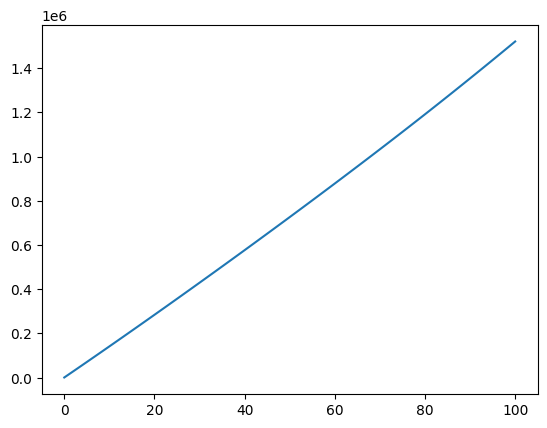

In [27]:
plt.plot(diction2['years'], diction2['Glacier Volume'])

Run model for 100 years


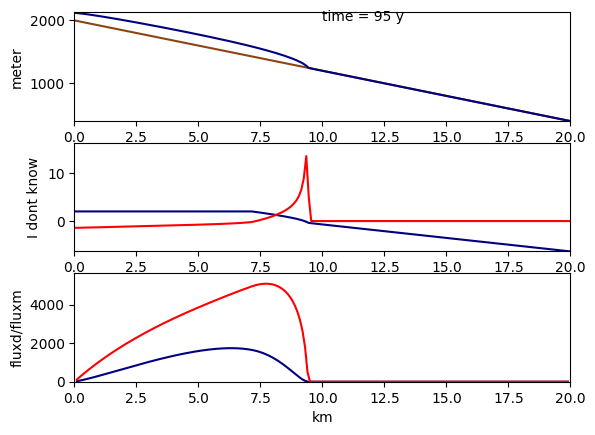

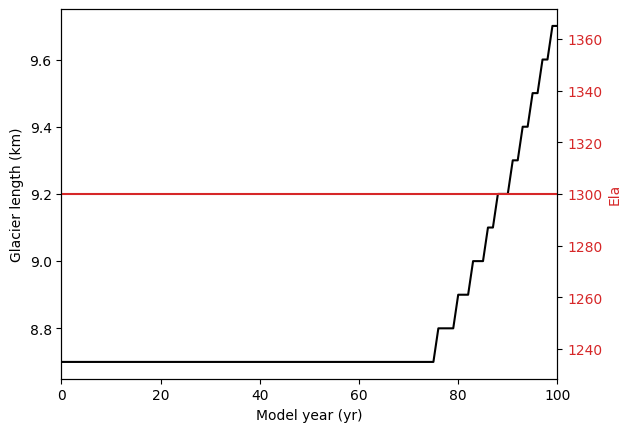

In [5]:
elalist=[1300]
elayear_initial=[100]

if __name__ == '__main__':
    diction2 = icemodel(elalist[::-1],elayear_initial,dx=100, FluxAtPoints=False)

In [4]:
def compute_response_time(diction, avgperiode=10, drift=None):
    glacier_length = np.array(diction['Glacier Length'])
    if drift is not None:
         glacier_length = glacier_length - np.array(drift['Glacier Length'])
    yearls = np.array(diction['years'])
    end_len = np.mean(glacier_length[-avgperiode:])
    start_len = glacier_length[0]
    threshold = start_len + (end_len - start_len) * (1 - 1/np.e)
    if glacier_length[0] < glacier_length[-1]: # glacier grows
        response_idx = np.argmax(glacier_length > threshold)
    else: # glacier shrinks
        response_idx = np.argmax(glacier_length < threshold)
    return yearls[response_idx]

In [5]:
def compute_mass_change(diction, avgperiode=10, drift=None):
    if drift is not None:
        volume = np.array(diction['Glacier Volume']) - np.array(drift['Glacier Volume'])
    else:
        volume = np.array(diction['Glacier Volume']) 
    mass_begin = volume[0] * rho
    mass_end = np.mean(volume[-avgperiode:]) * rho
    mass_change = mass_end - mass_begin
    return mass_change

In [6]:
def avg_smb(diction):
    '''calculate integrated surface mass balance at end of simulation'''
    smb = diction['smb']
    glacier_len = diction['Glacier Length'][-1]
    idx = int(glacier_len / diction['dx'])
    smb_int = np.mean(smb[:idx])
    return smb_int

In [139]:
# create initial states
import pickle
ela_initial_arr = [1600]#[1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
elayear_initial_arr = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
dx_initial = 2000

for idx, (ela_initial, elayear_initial) in enumerate(zip(ela_initial_arr, elayear_initial_arr)):

    name = f'initial_{ela_initial}m_{dx_initial}m_{elayear_initial}a'
    pklsave = os.path.join('..', 'Savestates', f'{name}.pkl')

    inital_state = icemodel([ela_initial], [elayear_initial],dx=dx_initial, FluxAtPoints=False, savename=name)
    
    with open(pklsave, 'wb') as f:
        pickle.dump(inital_state, f)

Run model for 1000 years


In [181]:
# replaced by functions below
ela_initial_arr = [1600]
elayear_initial_arr = [1000]

ela2test = np.arange(1300, 2001, 50)
all_response_times = []
all_delas = []
drift_response_times = []
dx_initial = 1000
for idx, (ela_initial, elayear_initial) in enumerate(zip(ela_initial_arr, elayear_initial_arr)):
    initial_name = f'initial_{ela_initial}m_{dx_initial}m_{elayear_initial}a'
    pklload = os.path.join('..', 'Savestates', f'{initial_name}.pkl')

    with open(pklload, 'rb') as f:
        loaded_initial = pickle.load(f)
    
    dx = 1000
    test_elayear = 300
    response_arr = []
    dela_arr = []
    drift_name = f'drift_{ela_initial}m_{dx}m_{test_elayear}a'
    model_drift = icemodel([ela_initial],[test_elayear],dx=dx, FluxAtPoints=False, initial_state=loaded_initial, savename=drift_name)
    for test_ela in ela2test:
        name = f'{test_ela}m_{dx}m_{test_elayear}a-vs-{initial_name}'
        model = icemodel([test_ela],[test_elayear],dx=dx, FluxAtPoints=False, initial_state=loaded_initial, savename=name)
        response_arr.append(compute_response_time(model, drift=model_drift))
        dela_arr.append(test_ela - ela_initial)
    all_response_times.append(response_arr)
    all_delas.append(dela_arr)

Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years
Run model for 300 years


In [105]:
def load_initial_state(ela_initial, dx_initial, elayear_initial):
    initial_name = f'initial_{ela_initial}m_{dx_initial}m_{elayear_initial}a'
    pklload = os.path.join('..', 'Savestates', f'{initial_name}.pkl')
    with open(pklload, 'rb') as f:
        loaded_initial = pickle.load(f)
    return loaded_initial, initial_name

def run_model(ela, elayear, dx, initial_state, name_suffix):
    name = f'{ela}m_{dx}m_{elayear}a-vs-{name_suffix}'
    model = icemodel([ela], [elayear], dx=dx, FluxAtPoints=False, initial_state=initial_state, savename=name)
    return model

def compute_responses(ela_initial, dx, test_elayear, initial_state, ela2test, mass_change=False):
    response_arr = []
    dela_arr = []
    mass_change_arr = []
    smb_arr = []
    initial_name = f'initial_{ela_initial}m_{dx}m_{test_elayear}a'
    drift_name = f'drift_{ela_initial}m_{dx}m_{test_elayear}a'
    model_drift = icemodel([ela_initial], [test_elayear], dx=dx, FluxAtPoints=False, initial_state=initial_state, savename=drift_name)
    for test_ela in ela2test:
        model = run_model(test_ela, test_elayear, dx, initial_state, initial_name)
        response_arr.append(compute_response_time(model, drift=model_drift))
        mass_change_arr.append(compute_mass_change(model, drift=model_drift))
        dela_arr.append(test_ela - ela_initial)
        smb_arr.append(avg_smb(model))
    if not mass_change:
        return response_arr, dela_arr, smb_arr
    else:
        return response_arr, dela_arr, smb_arr, mass_change_arr

ela_initial_arr = [1300]#, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
elayear_initial_arr = [1000]#, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
ela2test = np.arange(1300, 2001, 100)
all_response_times = []
all_delas = []
all_mass_changes = []
all_avg_smbs = []
dx_initial = 100

for idx, (ela_initial, elayear_initial) in enumerate(zip(ela_initial_arr, elayear_initial_arr)):
    loaded_initial, initial_name = load_initial_state(ela_initial, dx_initial, elayear_initial)
    dx = 100  # or vary dx here in a nested loop or however you plan to do it
    test_elayear = 1000
    response_arr, dela_arr, avg_smb_arr, mass_change_arr = compute_responses(ela_initial, dx, test_elayear, loaded_initial, ela2test, mass_change=True)
    all_response_times.append(response_arr)
    all_delas.append(dela_arr)
    all_mass_changes.append(mass_change_arr)
    all_avg_smbs.append(avg_smb_arr)

# TODO: something's still wrong with the mass stuff

Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years


In [30]:
def run_different_dx(dx):
    ela_initial_arr = [1600]#, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
    elayear_initial_arr = [1000]#, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
    ela2test = np.arange(1300, 2001, 100)
    all_response_times = []
    all_delas = []
    all_mass_changes = []
    all_avg_smbs = []
    dx_initial = dx

    for idx, (ela_initial, elayear_initial) in enumerate(zip(ela_initial_arr, elayear_initial_arr)):
        loaded_initial, initial_name = load_initial_state(ela_initial, dx_initial, elayear_initial)
        dx = dx  # or vary dx here in a nested loop or however you plan to do it
        test_elayear = 1000
        response_arr, dela_arr, avg_smb_arr, mass_change_arr = compute_responses(ela_initial, dx, test_elayear, loaded_initial, ela2test, mass_change=True)
        all_response_times.append(response_arr)
        all_delas.append(dela_arr)
        all_mass_changes.append(mass_change_arr)
        all_avg_smbs.append(avg_smb_arr)
    
    return all_response_times, all_delas, all_mass_changes, all_avg_smbs

In [64]:
dx_values = [50,100,150,200,250,300,350,400,450,500]  
dx_return_dict = {dx: run_different_dx(dx) for dx in dx_values}

with open('dx_return_dict.pickle', 'wb') as f:
    pickle.dump(dx_return_dict, f)


Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years


In [141]:
dx_values_new = [1000,1500,2000]  
dx_return_dict_new = {dx: run_different_dx(dx) for dx in dx_values_new}

with open('dx_return_dict_version_2.pickle', 'wb') as f:
    pickle.dump(dx_return_dict_new, f)


Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years


c:\Users\lasse\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\lasse\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years


c:\Users\lasse\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\lasse\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years
Run model for 1000 years


c:\Users\lasse\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\lasse\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [106]:
dx_return_dict

{50: ([[87, 84, 81, 0, 82, 81, 89, 104]],
  [[-300, -200, -100, 0, 100, 200, 300, 400]],
  [[1519160557.615753,
    1016819874.3673922,
    510007540.1654393,
    0.0,
    -524253974.05221796,
    -1078509964.7121122,
    -1706611566.1994247,
    -2179240604.425389]],
  [[0.01065318037751986,
    0.00954088666645055,
    0.016158064891841524,
    0.005874749519995291,
    0.007839418495545569,
    0.007245402241489571,
    0.010448061705874881,
    -0.027070892341864917]]),
 100: ([[87, 82, 84, 0, 80, 80, 89, 103]],
  [[-300, -200, -100, 0, 100, 200, 300, 400]],
  [[1519515163.753195,
    1014243531.4774363,
    510518800.25043523,
    0.0,
    -524107794.203479,
    -1078465143.9971383,
    -1706266813.185644,
    -2178934570.4375777]],
  [[0.010385775639673075,
    0.024005191827347,
    0.015866211892649525,
    0.005290246965110157,
    0.007210951402890145,
    0.006303346711056487,
    0.009364603074727744,
    -0.03455824517022413]]),
 150: ([[86, 85, 78, 0, 90, 82, 88, 106]],
 

In [50]:
dx_return_dict[300][1]


[[-300, -200, -100, 0, 100, 200, 300, 400]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


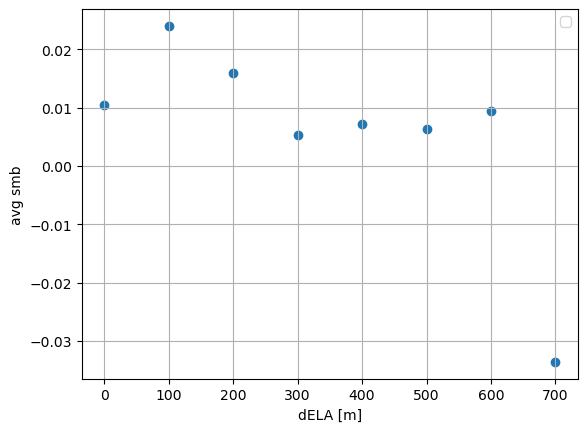

In [107]:
for idx, (rt, e) in enumerate(zip(all_response_times, all_delas)):
    plt.scatter(e, all_avg_smbs[idx])
    plt.legend()
    plt.grid(True)
    plt.xlabel('dELA [m]')
    plt.ylabel('avg smb')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


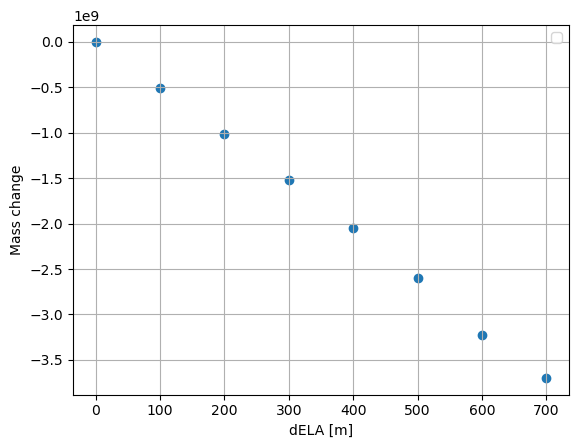

In [109]:
for idx, (rt, e) in enumerate(zip(all_response_times, all_delas)):
    # plt.scatter(e, rt, label=f'Initial ELA = {ela_initial_arr[idx]}')
    plt.scatter(e, all_mass_changes[idx])
    plt.legend()
    plt.grid(True)
    plt.xlabel('dELA [m]')
    plt.ylabel('Mass change')

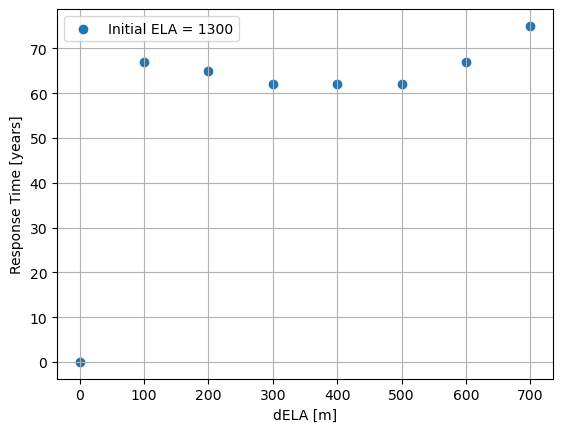

In [108]:
for idx, (rt, e) in enumerate(zip(all_response_times, all_delas)):
    plt.scatter(e, rt, label=f'Initial ELA = {ela_initial_arr[idx]}')
    # plt.scatter(e, all_mass_changes[idx])
    plt.legend()
    plt.grid(True)
    plt.xlabel('dELA [m]')
    plt.ylabel('Response Time [years]')

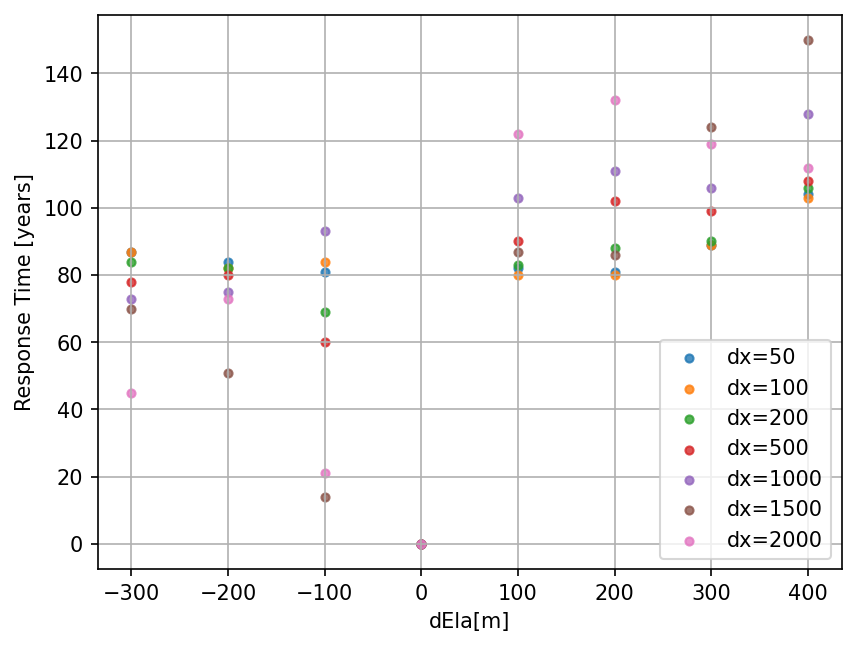

In [164]:
plt.figure(dpi=150)
dEla = dx_return_dict[100][1]
# Assuming `results_dict` is your dictionary of results
# for key, value in dx_return_dict.items():
#     plt.scatter(dEla[0], value[0][0] , label=f'dx={key}', marker='.')

plt.scatter(dEla, dx_return_dict[50][0], marker='o', label='dx=50',alpha=.8,s=15)
plt.scatter(dEla, dx_return_dict[100][0], marker='o', label='dx=100',alpha=.8,s=15)
plt.scatter(dEla, dx_return_dict[200][0], marker='o', label='dx=200',alpha=.8,s=15)
plt.scatter(dEla, dx_return_dict[500][0], marker='o', label='dx=500',alpha=.8,s=15)

for key, value in dx_return_dict_new.items():
    plt.scatter(dEla[0], value[0][0] , label=f'dx={key}', marker='o',alpha=.8,s=15)
plt.xlabel('dEla[m]')
plt.ylabel('Response Time [years]')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [135]:
dx_return_dict

{50: ([[87, 84, 81, 0, 82, 81, 89, 104]],
  [[-300, -200, -100, 0, 100, 200, 300, 400]],
  [[1519160557.615753,
    1016819874.3673922,
    510007540.1654393,
    0.0,
    -524253974.05221796,
    -1078509964.7121122,
    -1706611566.1994247,
    -2179240604.425389]],
  [[0.01065318037751986,
    0.00954088666645055,
    0.016158064891841524,
    0.005874749519995291,
    0.007839418495545569,
    0.007245402241489571,
    0.010448061705874881,
    -0.027070892341864917]]),
 100: ([[87, 82, 84, 0, 80, 80, 89, 103]],
  [[-300, -200, -100, 0, 100, 200, 300, 400]],
  [[1519515163.753195,
    1014243531.4774363,
    510518800.25043523,
    0.0,
    -524107794.203479,
    -1078465143.9971383,
    -1706266813.185644,
    -2178934570.4375777]],
  [[0.010385775639673075,
    0.024005191827347,
    0.015866211892649525,
    0.005290246965110157,
    0.007210951402890145,
    0.006303346711056487,
    0.009364603074727744,
    -0.03455824517022413]]),
 150: ([[86, 85, 78, 0, 90, 82, 88, 106]],
 

In [99]:
# print(dx for dx in dx_values)
print(list(dx_return_dict[dx][2] for dx in dx_values))

[[[1519160557.615753, 1016819874.3673922, 510007540.1654393, 0.0, -524253974.05221796, -1078509964.7121122, -1706611566.1994247, -2179240604.425389]], [[1519515163.753195, 1014243531.4774363, 510518800.25043523, 0.0, -524107794.203479, -1078465143.9971383, -1706266813.185644, -2178934570.4375777]], [[1513388162.640823, 1010953134.1205013, 510764657.18417555, 0.0, -530448890.9470159, -1081117886.3548386, -1707298817.9775646, -2178163341.347628]], [[1526388834.6976478, 1020137884.3832573, 517323442.623278, 0.0, -515839047.7370377, -1069476586.8049452, -1697051532.0904977, -2165769184.8185954]], [[1525606418.8533278, 1022920436.2651565, 517827668.3986346, 0.0, -520422750.453835, -1085487284.935419, -1701428426.8418324, -2169870460.5488987]], [[1516012965.2408326, 998322462.9504559, 510722590.8886199, 0.0, -531891715.0906578, -1081561867.01104, -1716553359.3141685, -2176681867.170096]], [[1508633073.388934, 990367578.7971342, 510256649.4759171, 0.0, -534205103.92276675, -1078082135.4807127

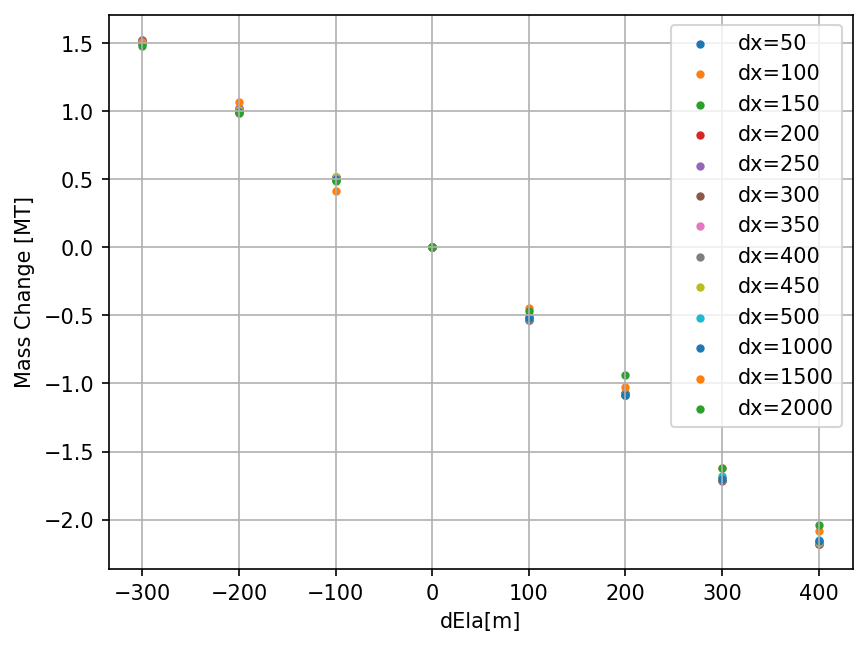

In [173]:
plt.figure(dpi=150)
dEla = dx_return_dict[100][1]
# Assuming `results_dict` is your dictionary of results
for key, value in dx_return_dict.items():
    plt.scatter(dEla[0], np.array(value[2][0])/1e9 , label=f'dx={key}', marker='.')
for key, value in dx_return_dict_new.items():
    plt.scatter(dEla[0], np.array(value[2][0])/1e9 , label=f'dx={key}', marker='.')

plt.xlabel('dEla[m]')
plt.ylabel('Mass Change [MT]')
# plt.title('Response Time for different dx')
plt.legend(loc='upper right')
plt.grid()
plt.show()


In [160]:
name = f'initial_1300m_100m_700a'
pklload = os.path.join('..', 'Savestates', f'{name}.pkl')
with open(pklload, 'rb') as f:
    loaded = pickle.load(f)

loaded['smb'].shape

(200,)

In [173]:
def avg_smb(diction):
    '''calculate integrated surface mass balance at end of simulation'''
    smb = diction['smb']
    glacier_len = diction['Glacier Length'][-1]
    idx = int(glacier_len / diction['dx'])
    smb_int = np.mean(smb[:idx])
    return smb_int

avg_smb(loaded)
# TODO: avg smb is not exactly 0 (and might never be) --> run controll runs and subtract model drift?
# added in response time and glacier mass change function

0.010383406919434124